In [1]:
import os
import random
import math
import itertools
import sys
from copy import deepcopy

import einops
import pandas as pd
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [2]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

# Step 1: Input data
X = np.array([
    [1, 2, 3, 2],
    [1, 1, 2, 4],
    [2, 2, 4, 1],
    [1, 0, 1, 1]
])  # Shape: (4, 4)
print("Input X:")
print(X)

# Step 2: Encoder layer 1 (W1: 3x4)
W1 = np.array([
    [1, 0, 1, -1],
    [0, 1, 0, 0],
    [-1, 0, -1, 0]
])  # Shape: (3, 4)

encoder_layer1 = relu(X @ W1.T)  # (4,4) @ (4,3) → (4,3)
print("\nEncoder Layer 1 Output (ReLU):")
print(encoder_layer1)

# Step 3: Encoder layer 2 (W2: 3x2)
W2 = np.array([
    [1, 0],
    [-1, 1],
    [1, 0]
])  # Shape: (3, 2)

encoded = relu(encoder_layer1 @ W2)  # (4,3) @ (3,2) → (4,2)
print("\nEncoded Output (Bottleneck):")
print(encoded)

# Step 4: Decoder layer 1 (W3: 2x3)
W3 = np.array([
    [1, 0, 1],
    [0, 1, 1]
])  # Shape: (2, 3)

decoder_layer1 = relu(encoded @ W3)  # (4,2) @ (2,3) → (4,3)
print("\nDecoder Layer 1 Output (ReLU):")
print(decoder_layer1)

# Step 5: Final decoder layer (W4: 3x4)
W4 = np.array([
    [1, 0, -1, 1],
    [-1, 0, 1, 0],
    [0, 1, 0, -1]
])  # Shape: (3, 4)

decoded = relu(decoder_layer1 @ W4)  # (4,3) @ (3,4) → (4,4)
print("\nDecoded Output (ReLU):")
print(decoded)



Input X:
[[1 2 3 2]
 [1 1 2 4]
 [2 2 4 1]
 [1 0 1 1]]

Encoder Layer 1 Output (ReLU):
[[2 2 0]
 [0 1 0]
 [5 2 0]
 [1 0 0]]

Encoded Output (Bottleneck):
[[0 2]
 [0 1]
 [3 2]
 [1 0]]

Decoder Layer 1 Output (ReLU):
[[0 2 2]
 [0 1 1]
 [3 2 5]
 [1 0 1]]

Decoded Output (ReLU):
[[0 2 2 0]
 [0 1 1 0]
 [1 5 0 0]
 [1 1 0 0]]


### Purpose of this notebook

Let us try to build a sparse autoencoder (SAE) that takes in some dummy variables in line with the representation that will be needed down the line!

The goal is to accomplish the following:

1. Construct an architecture like the one in the [Anthropic paper](https://transformer-circuits.pub/2023/monosemantic-features)
2. Define the appropriate losses of interest e.g: 
    - ReLU (April '24 update of Anthropic version, pre Scaling paper) [seen here](https://transformer-circuits.pub/2024/april-update/index.html#training-saes), while the newest Jan '25 update is much more in depth and complex with Gated etc. (see [here](https://transformer-circuits.pub/2025/january-update/index.html))
    - Gated SAE's
    - JumpReLU
    - TopK/BatchTopK/Matryoshka BatckTopK? (?)
3. Implement the training loop


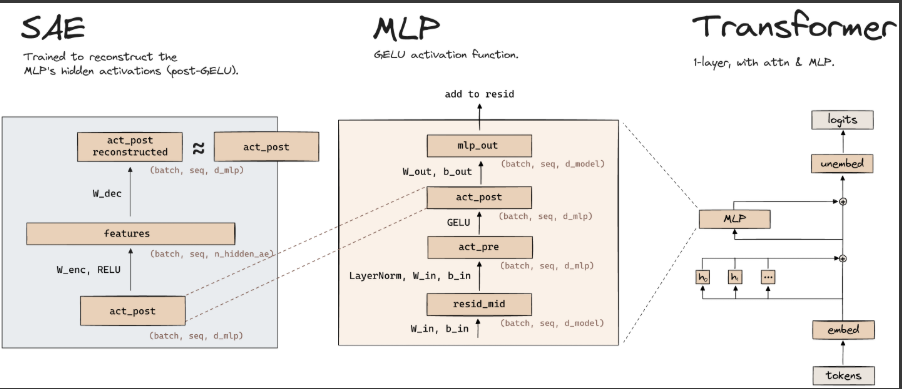

In [20]:
from dataclasses import dataclass
@dataclass
class SAEConfig:
    """Configuration for the Sparse Autoencoder (SAE) model.
    Args:
        d_in (int): Input dimension.
        d_sae (int): Dimension of the sparse autoencoder.
        sparsity_coeff (float): Coefficient for the sparsity penalty.
        weight_normalize_eps (float): Epsilon for weight normalization.
        tied_weights (bool): Whether to use tied weights for encoder and decoder.
        ste_epsilon (float): Epsilon for straight-through estimator.
    """
    d_in: int
    d_sae: int
    sparsity_coeff: float = 0.11
    

In [ ]:
class SparseAutoEncoder(nn.Module):
    """
    A one-layer autoencoder.
    """

    def __init__(self, cfg: SAEConfig,  resample_interval: int = 25_000) -> None:
        """
        act_dim : No. neuronal activation dimensions (from LLM)
        latent_dim : No. hidden layer dimensions (aka. the dictionary size)
        lmbda : sparsity parameter
        resample_interval : No. train steps for resampling dead neurons
        """
        super(SparseAutoEncoder, self).__init__()
        # TODO: assert cfg.d_in == model.cfg.d_hidden, "Model's hidden dim doesn't match SAE input dim."
        self.cfg = cfg
        self.act_dim, self.latent_dim = act_dim, latent_dim 
        # TODO: default PyTorch Kaiming uniform initalization
        # Decoder needs columns of unit norm
        # There's a bias attached to each one
        # x_bar = x - b_d
        
        # so they have a pre-bias from decoder -->
        # "We constrain the pre-encoder bias to equal the negative of the post-decoder bias and initialize it to the geometric median of the dataset. "
        # f = ReLU(W_e @ x_bar + b_e)
        # x_hat = W_d @ f + b_d
        # L = 1 / |X|    * sum_{x \in X} ||x - x_hat||^2 + lambda ||f||_1
        # W_e : encoder weight matrix (latent_dim x act_dim)
        # W_d : decoder weight matrix (act_dim x latent_dim)
        # b_e : encoder bias (latent_dim)
        # b_d : decoder bias (act_dim)
        # f : latent features (latent_dim)
        # x_hat : reconstructed activations (act_dim)
        self.relu = nn.ReLU()     
        
        # Init bias as zero
        self.b_enc = nn.Parameter(t.zeros(self.cfg.d_in))
        self.b_dec = nn.Parameter(t.zeros(self.cfg.d_sae)) # b_d
        self.encoder = nn.Parameter(self.cfg.d_in, self.cfg.d_sae) # nn.Linear uses kaiming uniform
        self.decoder = nn.Parameter(self.cfg.d_sae, self.cfg.d_in)
        self.W_dec_normalized() # Normalize the decoder's weight vectors to have unit norm along the feature (input) dimension.


    def encode(self, x):
        x_bar = x - self.b_dec # x_bar = x - b_d
        return self.relu( self.encoder(x_bar) + self.b_enc )  # f = ReLU(W_e @ x_bar + b_e)

    def decode(self, f):
        return self.decoder(f) + self.b_dec # x_hat = W_d_normalized @ f + b_d

    def forward(self, x):
        """
        Forward pass of an autoencoder.
        x : activations to be autoencoded
        output_features : if True, return the encoded features as well as the decoded x
        """
        latents = self.encode(x) # f = ReLU(W_e @ x_bar + b_e)
        reconstructed = self.decode(latents)
        loss = self.calculate_sae_loss(x, latents, reconstructed)
        if self.training:
            return {
                'loss': loss, 
                'latents': latents, 
                'reconst_acts': reconstructed}
        else:
            return {
                'loss': loss,
                'latents': latents,
                'reconst_acts': reconstructed,
                'mse_loss': self.mse_loss(reconstructed, x),
                'l1_loss': self.l1_loss(latents)
            }
            


    @t.no_grad()
    def W_dec_normalized(self):
        """
        Normalize the decoder's weight vectors to have unit norm along the feature dimension.
        This is important for the decoder to work properly. 
        """
        self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=0)
    
    def remove_parallel_component_of_decoder_grad(self):
        """
        Remove the component of the gradient parallel to the decoder's weight vectors.
        """
        unit_weights = F.normalize(self.decoder.weight, dim=0) # \hat{b}
        proj = (self.decoder.weight.grad * unit_weights).sum(dim=0) * unit_weights 
        self.decoder.weight.grad = self.decoder.weight.grad - proj


    def calculate_sae_loss(self, x, encoded, reconstructed):
        mse_loss = self.mse_loss(reconstructed, x)
        l1_loss = self.l1_loss(encoded)
        return mse_loss + self.lmbda * l1_loss

    def mse_loss(self, reconstructed, original):
        return F.mse_loss(reconstructed, original)

    def l1_loss(self, encoded):
        return F.l1_loss(encoded, t.zeros_like(encoded), reduction='sum') / encoded.shape[0]

Another note - the use of $b_{dec}$ here might seem weird, since we're subtracting it at the start then adding it back at the end. The way we're treating this term is as a **centralizing term for the hidden states**. It subtracts some learned mean vector from them so that $W_{enc}$ can act on centralized vectors, and then this term gets added back to the reconstructed hidden states at the end of the model.

------------

The toy model studied in [Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html) has some keen examples for guiding our intuition.

The input $x$ represents our five features (they're uniformly sampled between 0 and 1).

The justification for using $W^T W$ is as follows: we can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the features and bottleneck dimensions. The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:


In [4]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

import plotly.express as px

px.imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600, color_continuous_scale='RdBu')

As mentioned, you can view $W$ as being a set of five 2D vectors, one for each of our five features. 

The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

In [5]:
def plot_features_in_2d(W):
    """
    W is a tensor of shape (2, num_features)
    Plots each column vector as a point in 2D
    """
    # Plot each column vector
    plt.figure(figsize=(3, 3))
    for i in range(W.shape[1]):
        plt.plot([0, W[0, i].item()], [0, W[1, i].item()], 'k-')  # Line from origin
        plt.plot(W[0, i].item(), W[1, i].item(), 'ko')           # Dot at the end
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()

We can see two pairs of vectors (the 1st & 2nd, and the 0th & 4th) have very high cosine similarity.

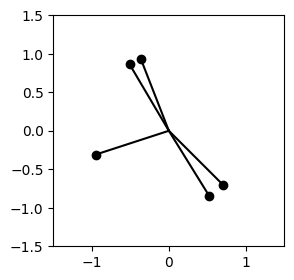

In [6]:
# Call the plotting function
plot_features_in_2d(W_normed)

Some dummy data to see if it learns something... Taken from [here](https://medium.com/data-science/sparse-autoencoder-from-superposition-to-interpretable-features-4764bb37927d)

In [7]:
data = t.tensor([
    # Cat categories
    [0.8, 0.3, 0.1, 0.05],  # "cat"
    [0.82, 0.32, 0.12, 0.06],  # "happy cat" (similar to "cat")
    # Dog categories
    [0.7, 0.2, 0.05, 0.2],  # "dog"
    [0.75, 0.3, 0.1, 0.25],  # "loyal dog" (similar to "dog")
    
    # "Not animal" categories
    [0.05, 0.9, 0.4, 0.4],  # "not cat"
    [0.15, 0.85, 0.35, 0.5],  # "not dog"
    
    # Robot and AI assistant (more distinct in 4D space)
    [0.0, 0.7, 0.9, 0.8],  # "robot"
    [0.1, 0.6, 0.85, 0.75]  # "AI assistant"
], dtype=t.float32)

Epoch [100/1000], Loss: 0.0339, L2 (Recon): 0.0168, L1 (sparsity): 1.7018
Epoch [200/1000], Loss: 0.0192, L2 (Recon): 0.0032, L1 (sparsity): 1.6016
Epoch [300/1000], Loss: 0.0160, L2 (Recon): 0.0018, L1 (sparsity): 1.4178
Epoch [400/1000], Loss: 0.0138, L2 (Recon): 0.0017, L1 (sparsity): 1.2136
Epoch [500/1000], Loss: 0.0119, L2 (Recon): 0.0017, L1 (sparsity): 1.0272
Epoch [600/1000], Loss: 0.0105, L2 (Recon): 0.0016, L1 (sparsity): 0.8876
Epoch [700/1000], Loss: 0.0096, L2 (Recon): 0.0016, L1 (sparsity): 0.7999
Epoch [800/1000], Loss: 0.0087, L2 (Recon): 0.0015, L1 (sparsity): 0.7188
Epoch [900/1000], Loss: 0.0079, L2 (Recon): 0.0015, L1 (sparsity): 0.6424
Epoch [1000/1000], Loss: 0.0071, L2 (Recon): 0.0013, L1 (sparsity): 0.5773


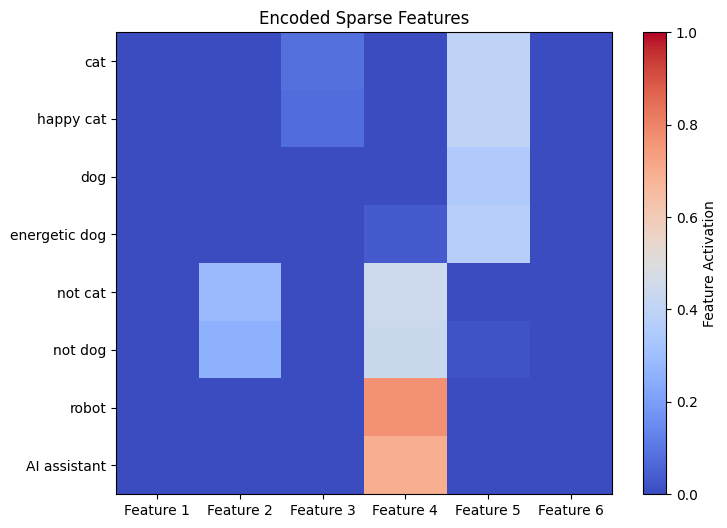

In [ ]:
import torch.optim as optim
# Define the dimensions for the dummy data
cfg = SAEConfig(d_in=4, d_sae = 6, sparsity_coeff=0.01)
act_dim = 4  # Number of input features
latent_dim = 6  # Number of latent features

num_epochs = 1000
learning_rate = 0.003
sparsity_coeff = 0.01


# Initialize the AutoEncoder
model = SparseAutoEncoder(act_dim=act_dim, latent_dim=latent_dim, lmbda=sparsity_coeff).to(device)
# Optimizer w. betas (0.9, 0.999), no weight decay. (Anthropic april)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set the model to training mode
model.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
# Forward pass
    encoded = model.encode(data)
    decoded = model.decode(encoded)

    reconstruction_loss = model.mse_loss(decoded, data) # MSE loss for reconstruction
    sparsity_loss = model.l1_loss(encoded)  # L1 loss for sparsity
    
    # Total loss
    # The SAE loss is a combination of the reconstruction loss and the sparsity loss
    loss = model.calculate_sae_loss(x=data, reconstructed=decoded, encoded=encoded)


    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 50 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, L2 (Recon): {reconstruction_loss.item():.4f}, L1 (sparsity): {sparsity_loss.item():.4f}")

# Visualization of encoded features
plt.figure(figsize=(8, 6))
encoded.cpu()
plt.imshow(encoded.detach().numpy(), cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label="Feature Activation")
plt.xticks(ticks=np.arange(latent_dim), labels=[f"Feature {i+1}" for i in range(latent_dim)])
plt.yticks(ticks=np.arange(len(data)), labels=["cat", "happy cat", "dog",  "energetic dog", "not cat", "not dog", "robot", "AI assistant"])
plt.title("Encoded Sparse Features")
plt.show()